## Topic discovery: yelp review

In [2]:
# from huggingface_hub import hf_hub_download 
import torch
from datasets import load_dataset, load_from_disk
import evaluate
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from transformers import TrainingArguments, Trainer
#from peft import LoraConfig, TaskType, get_peft_model
#from peft import PeftConfig, PeftModel
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import re
import os

In [3]:
print(transformers.__version__)

4.35.2


In [4]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu118
True


In [5]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

def load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=True, **kwargs):
    """
    if use load_in_4bit=True, do not set to_device=True
    kwargs:
        - device_map
        - torch_dtype
        - load_in_4bit
    """
    if not os.path.isfile(model_path + '/tokenizer.json'):
        print('no existing tokenizer found. Download from HF')
        tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                                  cache_dir=cache_dir,
                                                  **kwargs
                                                 ) # to load tokenizer to cache
    else:
        print('existing tokenizer found. Load from local')
        tokenizer = AutoTokenizer.from_pretrained(model_path, 
                                                  cache_dir=cache_dir, 
                                                  local_flies_only=True)
    if not os.path.isfile(model_path + '/model.safetensors'):
        print('no existing model found. Download from HF')
        model = AutoModelForClass.from_pretrained(model_name,
                                                     cache_dir=cache_dir,
                                                     **kwargs
                                                    )
    else:
        print('existing model found. Load from local')
        model = AutoModelForClass.from_pretrained(model_path, 
                                                 cache_dir=cache_dir,
                                                 local_files_only=True)
    
    if to_device:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        #device.reset()
        model.to(device) # use GPU. Do not need this if using load_in_4bit as it's already been set to the correct devices
        
    return tokenizer, model

In [11]:
llm_repo_dir = 'D:/projects/LLM'
cache_dir = '/cygdrive/d/projects/LLM/.cache'
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir + '/huggingface'
os.environ['XDG_CACHE_HOME'] = cache_dir
os.environ['HF_DATASETS_CACHE'] = cache_dir

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'google-bert/bert-base-cased'
model_path = cache_dir + '/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e'

dataset_path = cache_dir + '/parquet/yelp_polarity' # cache_dir + '/parquet/yelp_review_full-e22176106d6e7534'
dataset_name = 'yelp_polarity' # yelp_review_full
tokenized_data_path = cache_dir + '/tokenized_dataset_yelp_polarity_bert'

In [9]:
AutoModelForClass = AutoModelForSequenceClassification
to_device = True
tokenizer, model = load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=to_device)

existing tokenizer found. Load from local
existing model found. Load from local


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
if not os.path.isdir(dataset_path):
    dataset = load_dataset(dataset_name, cache_dir=cache_dir + '/parquet')
else:
    dataset = load_dataset(dataset_path)

In [ ]:
tokenized_datasets = load_from_disk(tokenized_data_path)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [24]:
print(type(small_train_dataset))
print(small_train_dataset.shape)

<class 'datasets.arrow_dataset.Dataset'>
(1000, 5)


In [26]:
input_ids = torch.tensor(small_train_dataset['input_ids'], device=device)

### use pre-trained BERT cls token as comment embedding

In [57]:
cls_embedding = []

with torch.no_grad():
    for i in range(input_ids.shape[0]):
        output = model(input_ids[i].reshape(1,-1),
                      output_hidden_states=True)
        cls_embedding.append(output.hidden_states[-1][0,0,:])

In [61]:
comment_embedding = np.array([x.cpu().numpy() for x in cls_embedding])

In [63]:
comment_embedding.shape

(1000, 768)

In [139]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca',PCA()),
                 ('tsne',TSNE(perplexity=20, learning_rate=0.1))
                ])

In [140]:
comment_embedding_tsne = pipe.fit_transform(comment_embedding)

D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


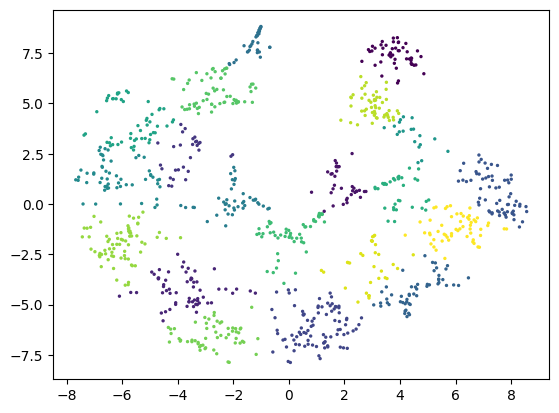

In [142]:
km = KMeans(n_clusters=20)
km.fit(comment_embedding_tsne)

plt.scatter(comment_embedding_tsne[:,0],
            comment_embedding_tsne[:,1], 
            s=2,
            c=km.labels_)

In [146]:
df_comment_from_label = pd.DataFrame({'comment':small_train_dataset['text'],
                                      'label':km.labels_,
                                      'sentiment':small_train_dataset['label']})

In [156]:
df_comment_from_label.groupby('label')['sentiment'].describe()[['count','mean','std']].sort_values('mean')

,count,mean,std
label,,,
5,66.0,0.333333,0.475017
0,49.0,0.367347,0.487078
17,53.0,0.377358,0.489364
6,52.0,0.384615,0.491251
19,57.0,0.403509,0.494962
2,61.0,0.426230,0.498632
15,57.0,0.438596,0.500626
18,31.0,0.451613,0.505879
10,19.0,0.473684,0.512989


In [150]:
df_comment_from_label[df_comment_from_label.label==5]

,comment,label,sentiment
11,Yay we have a Mellow Mushroom. Mellow Mushroom...,5,1
17,Todd English P.U.B. was just what I needed to ...,5,1
25,"I am usually not a great fan of crepes, but th...",5,1
54,"If you need to eat gluten free, stay away from...",5,0
60,I wish this restaurant was located at another ...,5,1
...,...,...,...
961,"First of all, a substitute sushi chef is like ...",5,0
970,One of my vacation rules is to indulge in the ...,5,1
971,We came out on a Saturday night. We understand...,5,0
981,This might be difficult to review based on one...,5,1


In [151]:
df_comment_from_label[df_comment_from_label.label==3]

,comment,label,sentiment
29,I am so excited to be here because it's yummy!...,3,1
104,Do not get a filling from this guy. I have to...,3,0
130,Before I thought grooming meant just a wash an...,3,1
154,Just tried this place with my boyfriend and it...,3,1
296,Just rented a space for our truck and trailer....,3,1
324,Great atmosphere and impeccable service!! Such...,3,1
388,The tacos are terrible. The shells are stale a...,3,0
413,I instantly saw results after two weeks of boo...,3,1
444,Very excited to try this place out. I tried t...,3,1
462,Love this Target! Never any lines. It seems wh...,3,1
